In [1]:
%config InlineBackend.figure_formats = {'png', 'retina'}
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### 복합 화력발전소 발전량
- feature
    - AT : 온도
    - V : 배기진공
    - AP : 주위압력
    - RH : 상대습도
- target
    - PE : 시간당 전기에너지 출력량

In [2]:
# 1. 데이터 로드

In [3]:
df = pd.read_csv("./data/thermal_power_plant.csv")
df.tail(2)

,AT,V,AP,RH,PE
9566,17.65,59.87,1018.58,94.65,450.93
9567,23.68,51.30,1011.86,71.24,451.67


In [4]:
# 2. 결정계수 확인 : df.corr() : 히트맵 시각화

In [5]:
df.corr()

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


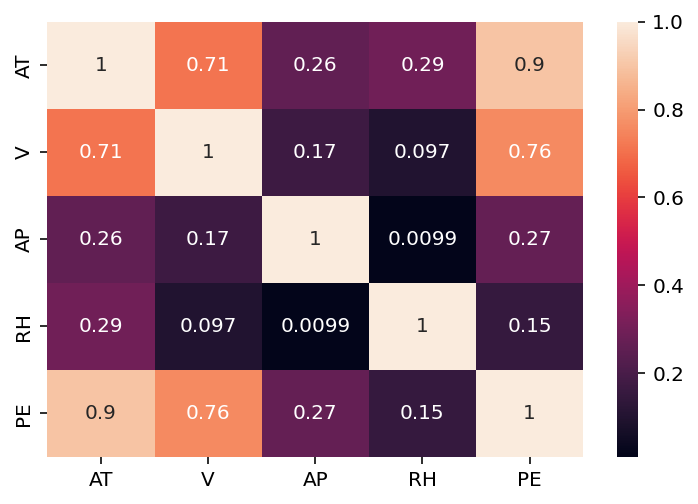

In [6]:
sns.heatmap(df.corr() ** 2, annot=True)
plt.show()

In [7]:
# 3. 데이터 전처리 : feature, target

In [8]:
df.columns

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

In [9]:
feature = df[['AT', 'V', 'AP', 'RH']]
target = df["PE"]
# feature = df[df.columns[:-1]]
# target = df.iloc[:, -1]

In [10]:
# 4. 모델학습 : sklearn

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
model = LinearRegression().fit(feature, target)

In [13]:
# 5. 모델성능 확인 : MAE

In [14]:
from sklearn.metrics import mean_absolute_error

In [15]:
pred = model.predict(feature)
mae = np.round(mean_absolute_error(target, pred), 2)
mae

3.63

In [16]:
# 'AT', 'V', 'AP', 'RH' : 3.63
# 'AT', 'V' : 3.92
# 'AT', 'AP' : 4.28
# 'AT', 'RH' : 3.8
# 2개의 feature를 사용할때 PE를 가장 잘 설명하는 AT, V를 사용하는것보다 AT, RH를 사용하는것이 더 좋다.
# 이유는 AT에 겹치지 않는 PE의 설명영역을 V보다 RH가 더 많이 설명하고 있기 때문이다.

In [17]:
# 6. 모델학습 : statsmodels

In [18]:
import statsmodels.api as sm

In [19]:
feature = df[['AT', 'V', 'AP', 'RH']]
target = df["PE"]
sm_feature = sm.add_constant(feature)
sm_feature.tail(1)

,const,AT,V,AP,RH
9567,1.0,23.68,51.3,1011.86,71.24


In [20]:
model = sm.OLS(target, sm_feature).fit()

In [21]:
# 7. 요약표 확인

In [22]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        16:53:55   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

In [23]:
print(model.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.929     
Dependent Variable: PE               AIC:                56186.2290
Date:               2022-05-25 16:53 BIC:                56222.0599
No. Observations:   9568             Log-Likelihood:     -28088.   
Df Model:           4                F-statistic:        3.114e+04 
Df Residuals:       9563             Prob (F-statistic): 0.00      
R-squared:          0.929            Scale:              20.778    
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|    [0.025    0.975] 
--------------------------------------------------------------------
const      454.6093    9.7485    46.6337  0.0000  435.5001  473.7184
AT          -1.9775    0.0153  -129.3420  0.0000   -2.0075   -1.9475
V           -0.2339    0.0073   -32.1221  0.0000   -0.2482   -0.2196
AP           0.0621    0.0095     6.5641  0.0000    0.0435  

In [24]:
# 8. 불필요한 컬럼을 제거
# (1) : 산점도 확인
# (2) : feature들 간의 상관계수 확인
# (3) : VIF 지표 사용 : feature들 간의 상관관계를 수치화 시켜준 데이터
#     : VIF 지표에서 10이상이 되는 feature는 제거 (한개씩 제거)

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [26]:
pd.DataFrame({
    "feature": feature.columns,
    "VIF": [variance_inflation_factor(feature.values, idx)
            for idx in range(feature.shape[1])]
})

,feature,VIF
0,AT,39.157705
1,V,74.969127
2,AP,66.618618
3,RH,40.704756


In [27]:
feature = df[['AT', 'AP', 'RH']]
pd.DataFrame({
    "feature": feature.columns,
    "VIF": [variance_inflation_factor(feature.values, idx)
            for idx in range(feature.shape[1])]
})

,feature,VIF
0,AT,10.821373
1,AP,64.595152
2,RH,36.414049


In [28]:
feature = df[['AT', 'RH']]
pd.DataFrame({
    "feature": feature.columns,
    "VIF": [variance_inflation_factor(feature.values, idx)
            for idx in range(feature.shape[1])]
})

,feature,VIF
0,AT,4.413538
1,RH,4.413538


In [29]:
# 9. 모델생성(feature: AT, RH), 성능 확인, 요약표 출력

In [30]:
feature = df[['AT', 'RH']]
target = df["PE"]
sm_feature = sm.add_constant(feature)

model = sm.OLS(target, sm_feature).fit()

print(model.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.921     
Dependent Variable: PE               AIC:                57169.2040
Date:               2022-05-25 16:53 BIC:                57190.7025
No. Observations:   9568             Log-Likelihood:     -28582.   
Df Model:           2                F-statistic:        5.572e+04 
Df Residuals:       9565             Prob (F-statistic): 0.00      
R-squared:          0.921            Scale:              23.031    
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|    [0.025    0.975] 
--------------------------------------------------------------------
const      516.4765    0.4014  1286.5877  0.0000  515.6896  517.2633
AT          -2.3907    0.0078  -305.0365  0.0000   -2.4061   -2.3753
RH          -0.2064    0.0040   -51.5944  0.0000   -0.2142   -0.1986
------------------------------------------------------------

In [31]:
# 'AT', 'V', 'AP', 'RH' : 3.63
# 'AT', 'V' : 3.92
# 'AT', 'AP' : 4.28
# 'AT', 'RH' : 3.8
# feature를 최소화 하면서 모델 성능의 감소를 최소화 시키는 방법은 AT, RH를 feature로 사용

pred = np.dot(sm_feature, model.params)
mae = np.round(mean_absolute_error(target, pred), 2)
mae

3.8